In [2]:
#############################################################################
################## -- Machine Learning Inmersion --##########################
####### Aprendizaje No Supervisado : Puntuación RFM ########
# Autor : André Chávez 

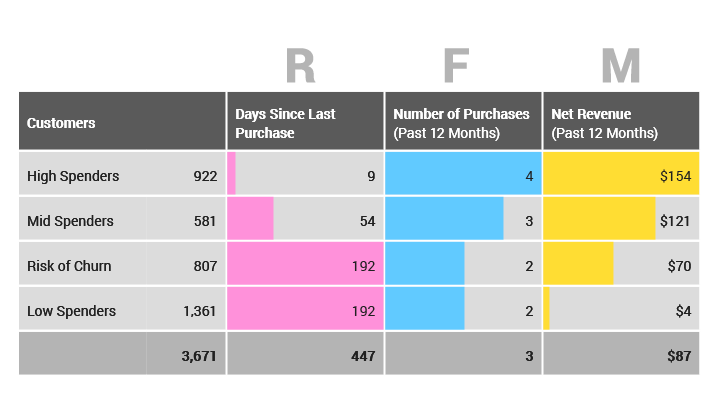

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
orders = pd.read_csv('C:/Users/Andre Chavez/Desktop/Datos/orders.csv',sep=';')

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
Fecha_Compra    5009 non-null object
ID_Compra       5009 non-null object
Cliente         5009 non-null object
Monto_Total     5009 non-null int64
dtypes: int64(1), object(3)
memory usage: 156.6+ KB


## Creamos la tabla RFM

Lo primero que debemos hacer es calcular la recencia, debemos evaluar cuál es la máxima fecha de compra del set de datos
o en todo caso ponernos en el día de hoy o la fecha máxima de evaluación.

In [8]:
import datetime as dt
NOW = dt.datetime(2014,12,31)

In [11]:
# De nuestro set de datos seleccionamos la columna de la fecha o el tiempo
orders['Fecha_Compra'] = pd.to_datetime(orders['Fecha_Compra'])

Create the RFM Table

In [12]:
rfmTable = orders.groupby('Cliente').agg({'Fecha_Compra': lambda x: (NOW - x.max()).days, # Recencia
                                        'ID_Compra': lambda x: len(x),      # Frecuencia
                                        'Monto_Total': lambda x: x.sum()}) # Monto

rfmTable['Fecha_Compra'] = rfmTable['Fecha_Compra'].astype(int)
rfmTable.rename(columns={'Fecha_Compra': 'recency', 
                         'ID_Compra': 'frequency', 
                         'Monto_Total': 'monetary_value'}, inplace=True)

## Validamos la Tabla RFM

In [13]:
rfmTable.head()

,recency,frequency,monetary_value
Cliente,,,
Aaron,12,17,5681
Adam,28,27,14261
Adrian,41,19,16267
Aimee,41,5,968
Alan,6,41,18460


Customer **Aaron Bergman** has frequency:3, monetary value:$887 and recency:415 days.

In [15]:
aaron = orders[orders['Cliente']=='Aimee']
aaron

,Fecha_Compra,ID_Compra,Cliente,Monto_Total
795,2011-03-05,CA-2011-169061,Aimee,706
1676,2012-09-10,CA-2012-168186,Aimee,15
2442,2013-01-31,CA-2013-147970,Aimee,16
3205,2014-09-05,CA-2014-120761,Aimee,92
3971,2014-11-20,CA-2014-158876,Aimee,139


Podemos poner la fecha de la máxima compra de Aaron y verificar si es correcta la recencia.

In [18]:
(NOW - dt.datetime(2014,12,19)).days==12

True

## Creamos los Cuartiles RFM

In [16]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [17]:
quantiles

,recency,frequency,monetary_value
0.25,15.25,7.0,2410.50
0.50,35.00,13.0,4920.00
0.75,78.50,19.0,9147.75


Creamos un diccionario con los cuantiles para facilitar su uso.

In [18]:
quantiles = quantiles.to_dict()

In [19]:
quantiles

{'recency': {0.25: 15.25, 0.5: 35.0, 0.75: 78.5},
 'frequency': {0.25: 7.0, 0.5: 13.0, 0.75: 19.0},
 'monetary_value': {0.25: 2410.5, 0.5: 4920.0, 0.75: 9147.75}}

## Creamos la segmentación RFM 

In [24]:
rfmSegmentation = rfmTable

In [25]:
# Argumentos (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Argumentos (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4


In [26]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [27]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [28]:
rfmSegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
Cliente,,,,,,,
Aaron,12,17,5681,4,3,3,433
Adam,28,27,14261,3,4,4,344
Adrian,41,19,16267,2,3,4,234
Aimee,41,5,968,2,1,1,211
Alan,6,41,18460,4,4,4,444


In [41]:
# Podemos guardar la información en formato csv para después analizarla.
#rfmSegmentation.to_clipboard()
#rfmSegmentation.to_csv('rfmtable.csv', sep=',')

Podríamos encontrar a los 5 mejores clientes ordenados por Monto Total de la compra?

In [29]:
# Nos quedamos con los mejores 5 clientes de acuerdo al monto.
rfmSegmentation[rfmSegmentation['RFMClass']=='444'].sort_values('monetary_value', ascending=False).head(5)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
Cliente,,,,,,,
Sanjit,9,32,30302,4,4,4,444
Rick,9,44,30287,4,4,4,444
Karen,4,28,24250,4,4,4,444
Ken,1,45,24067,4,4,4,444
Greg,2,31,23404,4,4,4,444


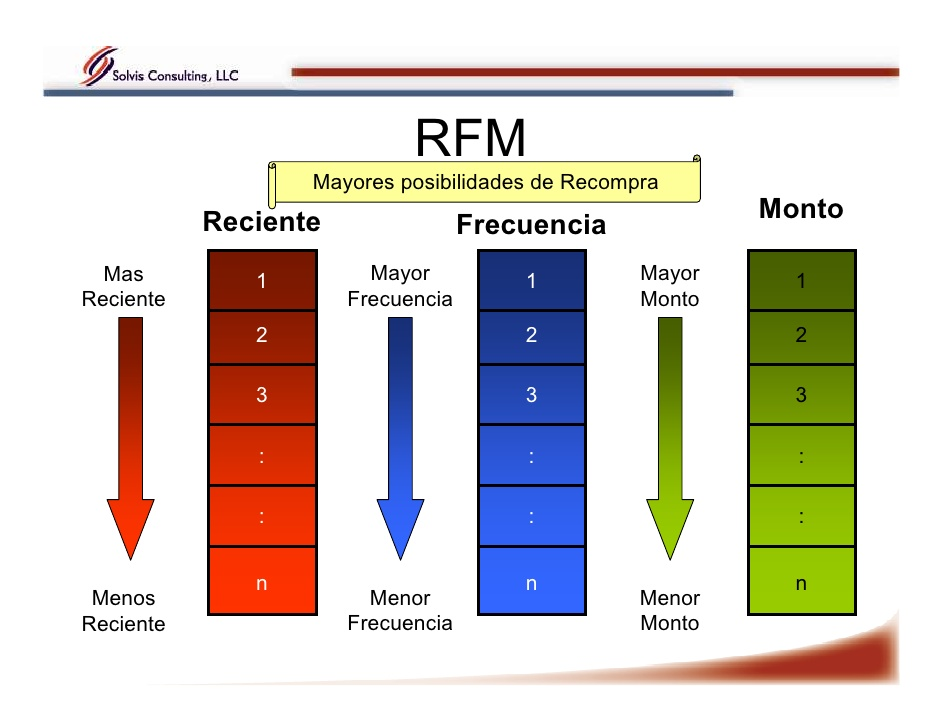

!!!!! FIN